In [2]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 2.1 MB/s 
     |████████████████████████████████| 40 kB 3.3 MB/s 
     |████████████████████████████████| 462 kB 45.2 MB/s 
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
import pathlib
data_dir = "/content/drive/My Drive/train/fruit"

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:


train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 351 files belonging to 2 classes.
Using 281 files for training.


In [7]:


val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 351 files belonging to 2 classes.
Using 70 files for validation.


In [8]:


class_names = train_ds.class_names
print(class_names)



['fresh_apples', 'rotten apples']


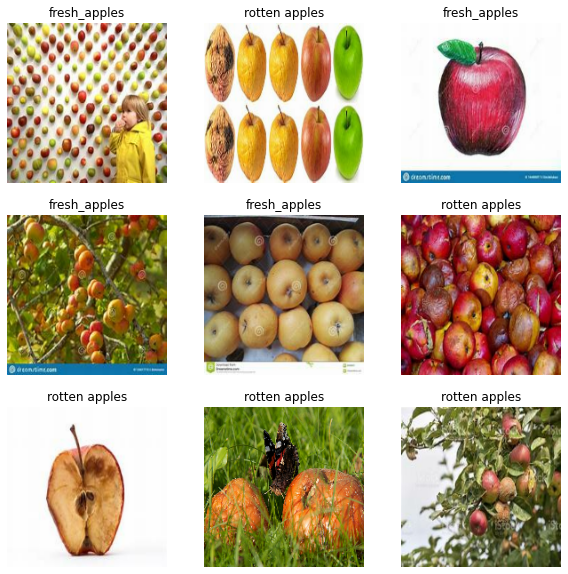

In [ ]:


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")



In [9]:


for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break



(32, 180, 180, 3)
(32,)


In [10]:


AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)



normalization_layer = layers.Rescaling(1./255)



normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 



num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



0.0 1.0


In [11]:


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [12]:


model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [19]:


epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)



Epoch 1/10
9/9 [==============================] - 8s 886ms/step - loss: 0.1613 - accuracy: 0.9537 - val_loss: 0.6210 - val_accuracy: 0.7714
Epoch 2/10
9/9 [==============================] - 8s 886ms/step - loss: 0.0936 - accuracy: 0.9573 - val_loss: 0.8599 - val_accuracy: 0.6857
Epoch 3/10
9/9 [==============================] - 8s 883ms/step - loss: 0.0523 - accuracy: 0.9893 - val_loss: 0.6866 - val_accuracy: 0.7571
Epoch 4/10
9/9 [==============================] - 8s 882ms/step - loss: 0.0320 - accuracy: 0.9964 - val_loss: 0.9854 - val_accuracy: 0.7286
Epoch 5/10
9/9 [==============================] - 8s 886ms/step - loss: 0.0260 - accuracy: 0.9929 - val_loss: 1.0773 - val_accuracy: 0.7571
Epoch 6/10
9/9 [==============================] - 9s 976ms/step - loss: 0.0187 - accuracy: 0.9964 - val_loss: 0.8237 - val_accuracy: 0.7000
Epoch 7/10
9/9 [==============================] - 8s 893ms/step - loss: 0.0167 - accuracy: 0.9929 - val_loss: 0.7812 - val_accuracy: 0.7000
Epoch 8/10
9/9 [====

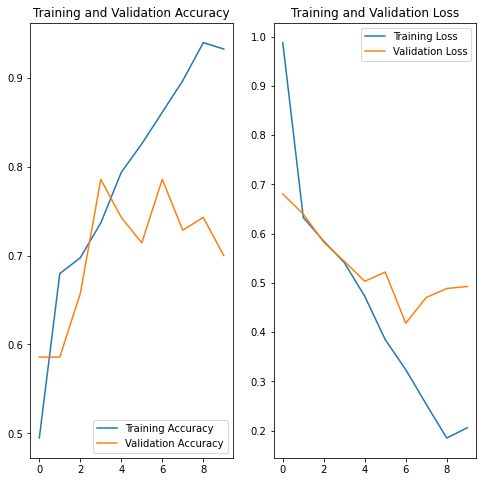

In [14]:


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



In [15]:


data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)



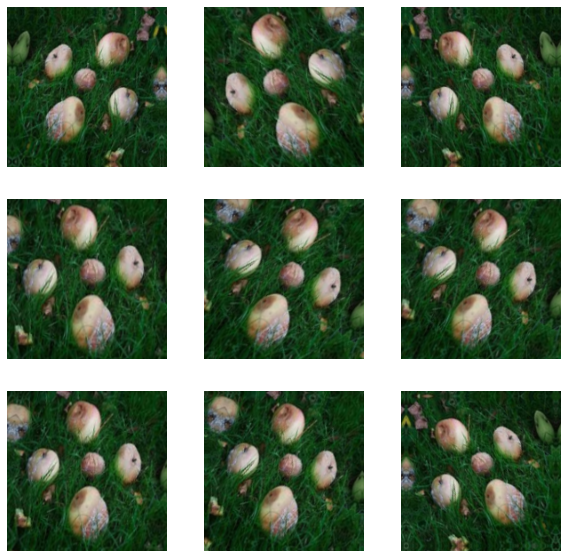

In [ ]:


plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")



In [21]:


apple_url = "https://images.freeart.com/comp/art-print/fa21893741/rotten-apple.jpg?pw=8.0&ph=10.0&fit=False&size=mobile390"
apple_path = tf.keras.utils.get_file('Red_sunflower', origin=apple_url)

img = tf.keras.utils.load_img(
    apple_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)



This image most likely belongs to rotten apples with a 87.93 percent confidence.


In [22]:
tfjs.converters.save_keras_model(model,'apple_model')